In [1]:
import os
import random
from glob import glob
from typing import Union, List

import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from tqdm import tqdm

from constants import LESION_SIZES

NIB_EXT = ".nii.gz"
DATA_DIR = "data/ATLAS_2/Training"

scans_filepaths = sorted(glob(os.path.join(DATA_DIR, "**/*_T1w" + NIB_EXT), recursive=True))
masks_filepaths = sorted(glob(os.path.join(DATA_DIR, "**/*T1lesion_mask" + NIB_EXT), recursive=True))

/home/neurone-pc11/miniconda3/envs/strokeformer/lib/python3.11/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


## Lesion Statistics
- Lesion volume distribution
- Lesion count per subject
- Lesion location distribution

In [2]:
from utils import get_lesion_distribution_metadata, plot_lesion_size_distribution


def plot_violin_lesion_size_distribution(area_counts: Union[np.ndarray, List[List[int]], List[np.ndarray]], labels, figsize=(8, 6), palette="Set3"):
    records = []
    for area_count, l in zip(area_counts, labels):
        for area in area_count:
            records.append(({"Lesion Size": l, "Lesion Area (voxels)": area}))

    df = pd.DataFrame(records, columns=["Lesion Area (voxels)", "Lesion Size"])

    plt.figure(figsize=figsize)
    sns.violinplot(data=df, x="Lesion Size", y="Lesion Area (voxels)", hue="Lesion Size", palette=palette, gap=0.5)
    sns.despine(left=True, bottom=True)


def plot_lesion_heatmap(masks: np.ndarray, figsize=(8, 6)):
    heatmap = np.zeros(masks[0].shape, dtype=np.float32)

    for mask in tqdm(masks, desc="Computing location heatmap"):
        heatmap += (mask > 0).astype(np.float32)

    heatmap /= len(masks)

    if heatmap.ndim == 3:
        mid_slice = heatmap.shape[-1] // 2
        heatmap = heatmap[..., mid_slice]

    plt.figure(figsize=figsize)
    plt.imshow(heatmap, cmap="hot")
    plt.colorbar(label="Frequency")
    plt.title(f"Lesion location heatmap")
    plt.axis("off")
    plt.show()


def plot_mask_slice(mask_path, slice_idx, category, ax=None, figsize=(8, 6)):
    if mask_path.endswith(".nii.gz"):
        mask = nib.load(mask_path).get_fdata()
    else:
        mask = np.load(mask_path)
    slice_mask = mask[..., slice_idx]

    if ax is None:
        plt.figure(figsize=figsize)
        plt.imshow(slice_mask, cmap="gray")
        plt.title(f"{category}")
        plt.axis("off")
        plt.show()
    else:
        ax.imshow(slice_mask, cmap="gray")
        ax.set_title(f"{category}")
        ax.axis("off")

In [3]:
lesion_distribution_metadata, masks = get_lesion_distribution_metadata(masks_filepaths, True)
counts_across_slices = [lesion_distribution_metadata[size]["count"] for size in LESION_SIZES]
counts_per_size = [lesion_distribution_metadata[size]["lesion_area"] for size in LESION_SIZES if size != "No Lesion"]

Loading masks: 100%|██████████| 655/655 [02:10<00:00,  5.00it/s]
Getting lesion distribution metadata: 655it [01:51,  5.89it/s]


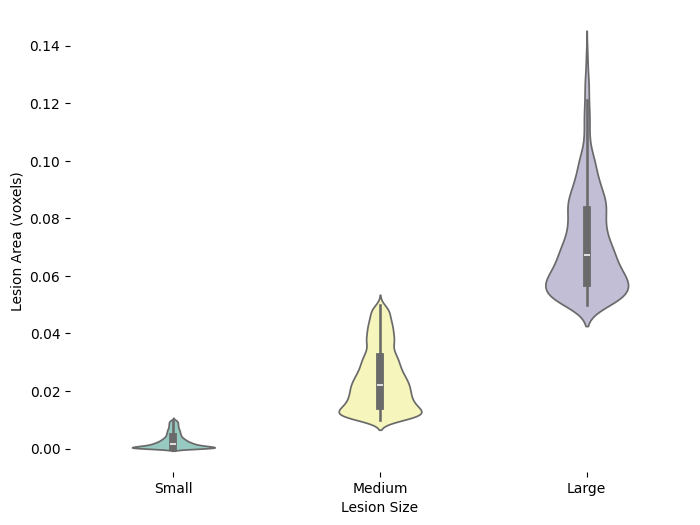

In [4]:
plot_violin_lesion_size_distribution(counts_per_size, [size for size in LESION_SIZES if size != "No Lesion"])

Total voxels: 5682314295
Total lesion voxels: 21760541.099999372
Lesion/Non-Lesion voxel ratio: 1:261.13

Total slices: 123795
Total slices without lesions: 90806
Total slices with lesions: 32989
Lesion/Non-Lesion slices ratio: 1:2.75

Average number of slices with lesions per patient: 50.36
Average number of lesions per patient: 5.11


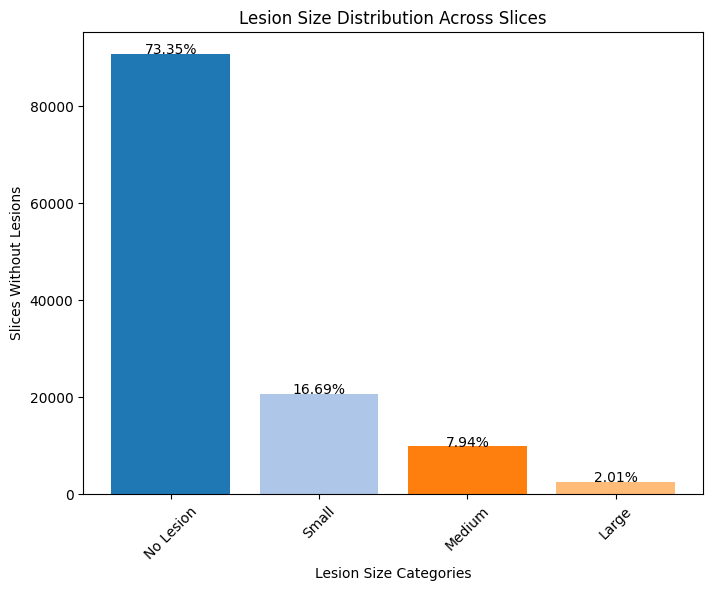

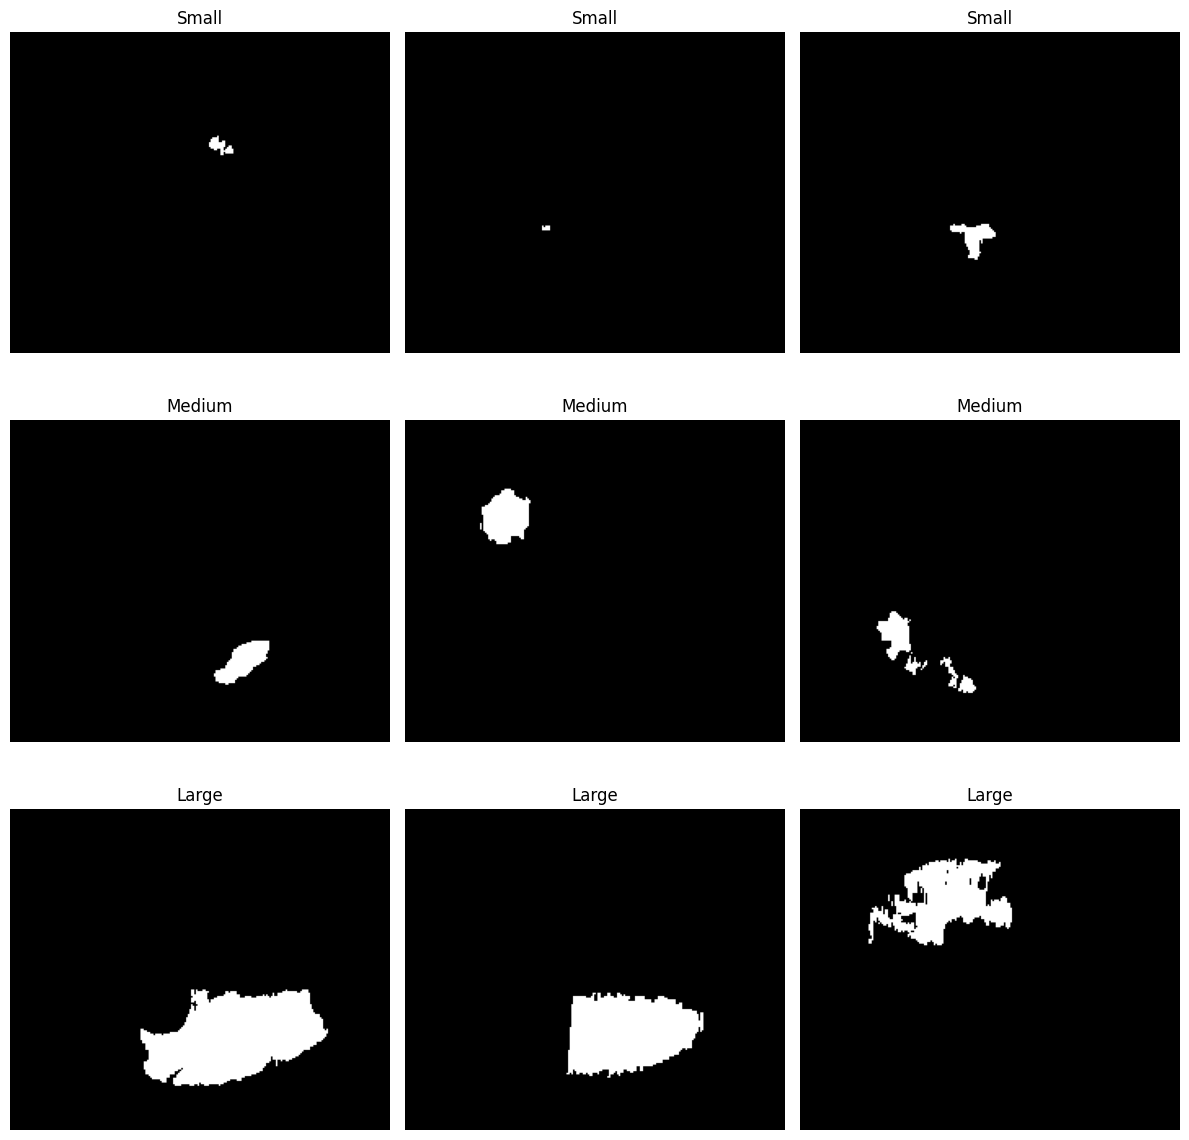

Computing location heatmap: 100%|██████████| 655/655 [00:34<00:00, 18.99it/s]


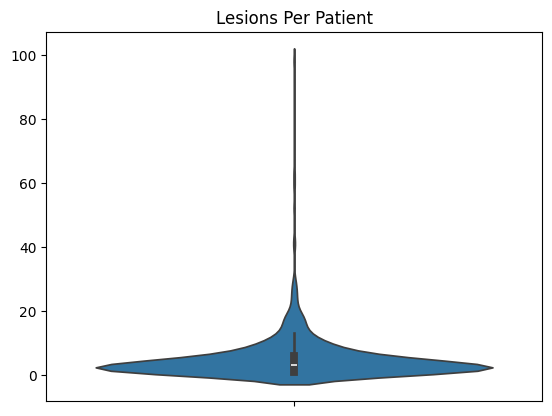

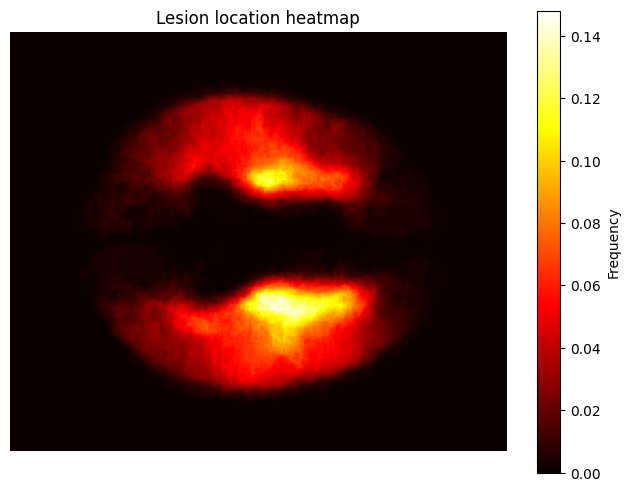

In [5]:
print(f"Total voxels: {lesion_distribution_metadata['tot_voxels']}\n"
      f"Total lesion voxels: {lesion_distribution_metadata['lesion_voxels']}\n"
      f"Lesion/Non-Lesion voxel ratio: 1:{lesion_distribution_metadata['tot_voxels'] / lesion_distribution_metadata['lesion_voxels']:.2f}\n\n"
      f"Total slices: {lesion_distribution_metadata['slices_without_lesions'] + lesion_distribution_metadata['slices_with_lesions']}\n"
      f"Total slices without lesions: {lesion_distribution_metadata['slices_without_lesions']}\n"
      f"Total slices with lesions: {lesion_distribution_metadata['slices_with_lesions']}\n"
      f"Lesion/Non-Lesion slices ratio: 1:{lesion_distribution_metadata['slices_without_lesions'] / lesion_distribution_metadata['slices_with_lesions']:.2f}\n\n"
      f"Average number of slices with lesions per patient: {lesion_distribution_metadata['slices_with_lesions'] / lesion_distribution_metadata['patients_count']:.2f}\n"
      f"Average number of lesions per patient: {np.mean(lesion_distribution_metadata['lesions_per_patient']):.2f}")

plot_lesion_size_distribution(counts_across_slices, LESION_SIZES)


fig, axs = plt.subplots(3, 3, figsize=(12, 12))
masks_samples = []

for i, size in enumerate(LESION_SIZES[1:]):
    samples = random.choices(lesion_distribution_metadata[size]["filepaths"], k=3)

    for j, (filepath, slice_idx) in enumerate(samples):
        plot_mask_slice(filepath, slice_idx, size, ax=axs[i, j])

plt.tight_layout()
plt.show()

sns.violinplot(lesion_distribution_metadata['lesions_per_patient'])
plt.title("Lesions Per Patient")

plot_lesion_heatmap(masks)